### Andrew Taylor
### atayl136
### Creating AI Enabled Systems



# Demo Index Notebook
This notebook demonstrates the indexing and nearest neighbor search using three FAISS indices: **BruteForce**, **HNSW**, and **LSH**. We precompute embeddings for all images in `storage/gallery/*`, load them into the indices, and benchmark the search runtimes.


In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys


# Add the "modules" directory (one level up from notebooks) to the system path.
sys.path.insert(0, os.path.abspath(os.path.join('..', 'modules')))


# Import index classes 
from retrieval.index.bruteforce import FaissBruteForce
from retrieval.index.hnsw import FaissHNSW
from retrieval.index.lsh import FaissLSH


In [2]:


from PIL import Image
import torch
import numpy as np
from pathlib import Path
import os
import sys

# Add the modules directory to the path if needed
sys.path.insert(0, os.path.abspath(os.path.join('..', 'modules')))

from extraction.embedding import Embedding
from extraction.preprocessing import Preprocessing

# Initialize the preprocessing pipeline and embedding model once.
preprocessing = Preprocessing(image_size=160)
device = 'cpu'
embedding_model = Embedding(pretrained='casia-webface', device=device)


def compute_batch_embeddings(image_paths, batch_size=32):
    """
    Compute embeddings for a list of image paths in batches.
    """
    embeddings = []
    metadata = []
    batch_images = []
    batch_names = []
    
    for path in image_paths:
        p = Path(path)
        # Skip files starting with "._"
        if p.name.startswith("._"):
            continue
        try:
            image = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")
            continue
        
        processed_image = preprocessing.process(image)
        batch_images.append(processed_image)
        batch_names.append(p.name)
        
        if len(batch_images) == batch_size:
            batch_tensor = torch.cat(batch_images, dim=0)
            batch_embeddings = embedding_model.encode(batch_tensor)
            if batch_embeddings.ndim == 1:
                batch_embeddings = np.expand_dims(batch_embeddings, axis=0)
            for emb in batch_embeddings:
                embeddings.append(emb)
            metadata.extend(batch_names)
            batch_images = []
            batch_names = []
    
    if batch_images:
        batch_tensor = torch.cat(batch_images, dim=0)
        batch_embeddings = embedding_model.encode(batch_tensor)
        if batch_embeddings.ndim == 1:
            batch_embeddings = np.expand_dims(batch_embeddings, axis=0)
        for emb in batch_embeddings:
            embeddings.append(emb)
        metadata.extend(batch_names)
    
    return embeddings, metadata

# Set the gallery directory
gallery_dir = Path('../storage/multi_image_gallery')
image_paths = [
    str(p) for p in gallery_dir.rglob('*') 
    if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png'} and not p.name.startswith("._")
]
print(f"Found {len(image_paths)} images in gallery.")

# Compute embeddings in batches.
embeddings, metadata = compute_batch_embeddings(image_paths, batch_size=32)
embeddings = np.array(embeddings)
print(f"Processed {len(embeddings)} images with embeddings.")

# Import FAISS (will be correctly handled in the index classes)
import faiss
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="True" 

# Import the index classes
from retrieval.index.bruteforce import FaissBruteForce
from retrieval.index.hnsw import FaissHNSW
from retrieval.index.lsh import FaissLSH

try:
    # Create the indices on CPU
    print("Creating BruteForce index...")
    bf_index = FaissBruteForce(dim=512, metric='euclidean')
    print(f"BruteForce index dimension: {bf_index.index.d}")
    
    print("Creating HNSW index...")
    hnsw_index = FaissHNSW(dim=512, M=32, efConstruction=40)
    print(f"HNSW index dimension: {hnsw_index.index.d}")
    
    print("Creating LSH index...")
    lsh_index = FaissLSH(dim=512, nbits=128)
    print(f"LSH index dimension: {lsh_index.index.d}")
    
    # Check embeddings shape
    print(f"Embeddings shape: {embeddings.shape}")
    if len(embeddings.shape) != 2:
        raise ValueError(f"Embeddings must be 2D, got shape {embeddings.shape}")
    
    # Ensure embeddings is a NumPy array of type float32
    embeddings = embeddings.astype('float32')
    
    # Check dimensions match before adding
    embedding_dim = embeddings.shape[1]
    if embedding_dim != bf_index.index.d:
        raise ValueError(f"BruteForce index dimension ({bf_index.index.d}) doesn't match embeddings dimension ({embedding_dim})")
    if embedding_dim != hnsw_index.index.d:
        raise ValueError(f"HNSW index dimension ({hnsw_index.index.d}) doesn't match embeddings dimension ({embedding_dim})")
    if embedding_dim != lsh_index.index.d:
        raise ValueError(f"LSH index dimension ({lsh_index.index.d}) doesn't match embeddings dimension ({embedding_dim})")
    
    # Add embeddings to each index
    print("Adding embeddings to BruteForce index...")
    bf_index.metadata.extend(metadata)
    bf_index.index.add(embeddings)
    
    #print("Adding embeddings to HNSW index...")
    hnsw_index.metadata.extend(metadata)
    hnsw_index.index.add(embeddings)
    
    print("Adding embeddings to LSH index...")
    lsh_index.metadata.extend(metadata)
    lsh_index.index.add(embeddings)
    
    print("Embeddings added to all indices.")
    
except Exception as e:
    print(f"Error during index creation or embedding addition: {e}")

Found 2265 images in gallery.
Processed 2265 images with embeddings.
Creating BruteForce index...
BruteForce index dimension: 512
Creating HNSW index...
HNSW index dimension: 512
Creating LSH index...
LSH index dimension: 512
Embeddings shape: (2265, 512)
Adding embeddings to BruteForce index...
Adding embeddings to LSH index...
Embeddings added to all indices.


In [3]:
# Benchmark a sample query on each index.
query_embedding = embeddings[0].reshape(1, -1)
k = 5  # Number of nearest neighbors

def benchmark_search(index, index_name):
    start_time = time.time()
    distances, indices = index.index.search(query_embedding, k)
    elapsed_time = time.time() - start_time
    return elapsed_time, distances, indices

results = {}
for idx_obj, name in zip([bf_index, hnsw_index, lsh_index], ["BruteForce", "HNSW", "LSH"]):
    elapsed, dists, inds = benchmark_search(idx_obj, name)
    results[name] = {'Time (s)': elapsed, 'Distances': dists, 'Indices': inds}
    print(f"{name} search time: {elapsed:.6f} seconds")
    print(f"Distances: {dists}")
    print(f"Indices: {inds}\n")


BruteForce search time: 0.002006 seconds
Distances: [[0.         0.4043184  0.4439362  0.4460613  0.46177876]]
Indices: [[   0  936  816 2104 1731]]

HNSW search time: 0.000000 seconds
Distances: [[0.         0.4043184  0.4439362  0.4460613  0.46177876]]
Indices: [[   0  936  816 2104 1731]]

LSH search time: 0.000000 seconds
Distances: [[ 0. 20. 21. 21. 22.]]
Indices: [[   0  936 1313 2038 1238]]



        Index  Search Time (s)
0  BruteForce         0.002006
1        HNSW         0.000000
2         LSH         0.000000


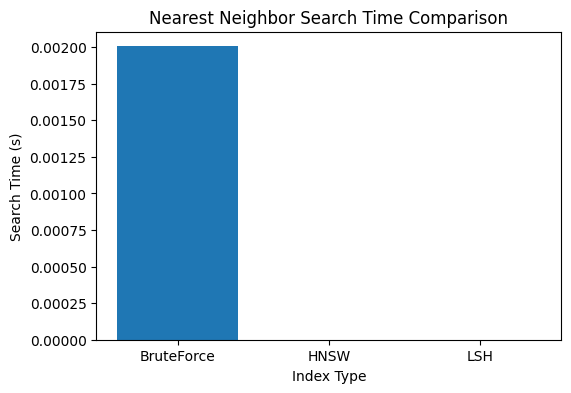

In [4]:
# Compile benchmarking results into a DataFrame.
df = pd.DataFrame({
    'Index': list(results.keys()),
    'Search Time (s)': [results[name]['Time (s)'] for name in results]
})
print(df)

# Plot the search times.
plt.figure(figsize=(6, 4))
plt.bar(df['Index'], df['Search Time (s)'])
plt.xlabel('Index Type')
plt.ylabel('Search Time (s)')
plt.title('Nearest Neighbor Search Time Comparison')
plt.show()


## Insights

- The **BruteForce** index performs an exact search, which may become slow with a large number of embeddings.
- The **HNSW** and **LSH** indices provide approximate searches that can greatly improve search speed while trading off a bit of accuracy.
- Factors such as dataset size, embedding dimensionality, and index-specific parameters (e.g., `M`, `efConstruction`, `nbits`) impact overall performance.
